In [1]:
from __future__ import print_function

### VGP notebook 4 LSTM Gradients check

In [2]:
# Load data and imports
import numpy as np
from numpy import array, asarray, zeros
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
#tf.enable_eager_execution()
from keras import Input, Model
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import BatchNormalization, PReLU
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import RNN, LSTMCell, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping, LambdaCallback, TensorBoard

# Hyperas for hyperparameter selection
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

from keras import backend as k
#tf.compat.v1.disable_eager_execution()
import os 

### Modified data, compare RNN and LSTM

In [16]:
train= pd.read_csv('/Users/necromancerchenmy/Desktop/honours_thesis/thesis/thesis_proposal/NLP tutorial/Toxic comment data/jigsaw-toxic-comment-train.csv')
train.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)
    
sentences_t= train[train['toxic']== 1]
sentences_nt= train[train['toxic']== 0]
# Take almost all the toxic sentences
sentences_t= sentences_t[:20000]
sentences_nt= sentences_nt[:20000]
sentences_half= pd.concat([sentences_t, sentences_nt])

# Shuffle the half-half data:
sentences_half = sentences_half.sample(frac=1).reset_index(drop=True)
sentences_half.head()


,id,comment_text,toxic
0,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0
1,20261c797df693db,Nationality \n\nEvery comedian or writer from ...,0
2,4445493f1e674803,:: The part of women and Jews is absurd and ir...,1
3,2ba10bd81c50911e,You are addressing none of the points provided...,0
4,c407480d0c7d0aed,you're gay \n\nyou're the biggest drama-queen...,1


In [17]:
# Replace last 30% of each sentence with irrelevant words:
idx= 0.3
sentences_mod= sentences_half.copy()
for i in range(len(sentences_mod)):
    sentence= sentences_mod['comment_text'].iloc[i]
    split_sent= str(sentence).split()
    sent_length= len(split_sent)
    n_rep= int(np.floor(sent_length* idx))
    split_sent[-n_rep:]= ['the']*n_rep
    sentences_mod['comment_text'].iloc[i]= ' '.join(word for word in split_sent)  


In [18]:
print(sentences_half['comment_text'].iloc[30001])
sentences_mod['comment_text'].iloc[30001]


"

Wait.  You're not going to block me for posting an RFC?

Or did you block me just so that I couldn't go advertising the RFC on other pages where it might be relevant?

See.  There's the problem. As a non-admin, I am liable to be blackballed by admins, some of whom suffer from Projection (or do they merely think sophistry is administration?):

I performed no personal attacks.  I made analogies between admin behavior and classical abuse of power.
I was personally attacked. No admins have been blocked.

I was not trolling.  Calling me a troll is nothing but a lie designed to anger me and cause me to overreact.  It's an attempt to fabricate ""evidence"" for a block.
At least one admin thinks my being called a troll is enough evidence, because now I am blocked. (And I seriously doubt any admin is reading this page).

I was not disrupting anything and I am not posting in any inappropriate manner.  I was discussing the problem in the forum provided.  Blocking people to stop them from winni

'" Wait. You\'re not going to block me for posting an RFC? Or did you block me just so that I couldn\'t go advertising the RFC on other pages where it might be relevant? See. There\'s the problem. As a non-admin, I am liable to be blackballed by admins, some of whom suffer from Projection (or do they merely think sophistry is administration?): I performed no personal attacks. I made analogies between admin behavior and classical abuse of power. I was personally attacked. No admins have been blocked. I was not trolling. Calling me a troll is nothing but a lie designed to anger me and cause me to overreact. It\'s an attempt to fabricate ""evidence"" for a block. At least one admin thinks my being called a troll is enough evidence, because now I am blocked. (And I seriously doubt any admin is reading this page). I was not disrupting anything and I am not posting in any inappropriate manner. I was discussing the problem in the forum provided. Blocking people to stop them from winning an ar

In [19]:
xm= sentences_mod['comment_text']; ym= sentences_mod['toxic']
# Tokenise data
tok_m= text.Tokenizer()
tok_m.fit_on_texts(list(xm))
input_dim_m= len(tok_m.word_index)+1
input_length_m= sentences_half['comment_text'].apply(lambda x: len(str(x).split())).max()
xm_seq= tok_m.texts_to_sequences(xm)
longmod_pad= sequence.pad_sequences(xm_seq, maxlen= input_length_m)
print('Shape of long modified sentences input object:', longmod_pad.shape)
print('Max len of long modified sentences:', input_length_m)

output_dim= 100
# Word embeddings
def embed_mat(input_dim, output_dim, tok):
    '''By default output_dim = 100 for GloVe 100d embeddings'''
    embedding_dict=dict()
    f= open('/Users/necromancerchenmy/Desktop/honours_thesis/thesis/thesis_proposal/NLP tutorial/GloVe/glove.6B.100d.txt')
    for line in f:
        values= line.split()
        word= values[0]; coefs= asarray(values[1:], dtype= 'float32')
        embedding_dict[word]= coefs
    f.close()
    Emat= zeros((input_dim, output_dim))
    for word, i in tok.word_index.items():
        embedding_vector= embedding_dict.get(word)
        if embedding_vector is not None:
            Emat[i]= embedding_vector
    print('Embedding weight matrix has shape:', Emat.shape)
    return Emat
Emat_m= embed_mat(input_dim_m, output_dim, tok_m)


Shape of long modified sentences input object: (40000, 2321)
Max len of long modified sentences: 2321
Embedding weight matrix has shape: (64144, 100)


In [7]:
# Define RNN model
batch_size = 100
inp= Input(batch_shape= (batch_size, input_length_m), name= 'input') 
emb_out= Embedding(input_dim_m, output_dim, input_length= input_length_m, 
                         weights= [Emat_m], trainable= False, name= 'embedding')(inp)
rnn= SimpleRNN(200, return_sequences= True, return_state= False, stateful= False, name= 'rnn')

h0 = tf.Variable(tf.random.uniform((batch_size, 200)))
rnn_allstates= rnn(emb_out, initial_state=h0)  

model_rnn_mod = Model(inputs=inp, outputs= rnn_allstates, name= 'model_RNN')
model_rnn_mod.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model_rnn_mod.summary()


Model: "model_RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(100, 2321)]             0         
_________________________________________________________________
embedding (Embedding)        (100, 2321, 100)          4741100   
_________________________________________________________________
rnn (SimpleRNN)              (100, 2321, 200)          60200     
Total params: 4,801,300
Trainable params: 60,200
Non-trainable params: 4,741,100
_________________________________________________________________


In [15]:
# Define LSTM model
batch_size = 100
inp= Input(batch_shape= (batch_size, input_length_m), name= 'input') 
emb_out= Embedding(input_dim_m, output_dim, input_length= input_length_m, 
                         weights= [Emat_m], trainable= False, name= 'embedding')(inp)

class LSTMCellwithStates(LSTMCell):
    def call(self, inputs, states, training=None):
        real_inputs = inputs[:,:self.units] # decouple [h, c]
        outputs, [h,c] = super().call(real_inputs, states, training=training)
        return tf.concat([h, c], axis=1), [h,c]
    
rnn = RNN(LSTMCellwithStates(200), return_sequences= True, return_state= False, name= 'LSTM') 

h0 = tf.Variable(tf.random.uniform((batch_size, 200)))
c0 = tf.Variable(tf.random.uniform((batch_size, 200)))
rnn_allstates= rnn(emb_out, initial_state=[h0, c0])  

model_lstm_mod = Model(inputs=inp, outputs= rnn_allstates[:, :, 200:], name= 'model_LSTMCell')
model_lstm_mod.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model_lstm_mod.summary()

Model: "model_LSTMCell"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(100, 2321)]             0         
_________________________________________________________________
embedding (Embedding)        (100, 2321, 100)          6414400   
_________________________________________________________________
LSTM (RNN)                   (100, 2321, 400)          240800    
_________________________________________________________________
tf.__operators__.getitem (Sl (100, 2321, 200)          0         
Total params: 6,655,200
Trainable params: 240,800
Non-trainable params: 6,414,400
_________________________________________________________________


## First 20 steps

#### RNN grads

In [10]:
ds = tf.data.Dataset.from_tensor_slices((longmod_pad[:100], ym[:100])).batch(100)
@tf.function
def calculate_t_gradients(t, x, h0):
    return tf.gradients(model_rnn_mod(x)[:,t,:], h0)
for b, (x_batch_train, y_batch_train) in enumerate(ds): 
    t= 0
    grad= calculate_t_gradients(t, x_batch_train, h0)
    print(grad)
    

[<tf.Tensor: shape=(100, 200), dtype=float32, numpy=
array([[-0.97025084, -0.10700837, -0.535621  , ...,  0.16738516,
         1.0935475 , -1.3837934 ],
       [-1.1610013 , -0.18692441, -0.44146577, ...,  0.3021364 ,
         1.0710173 , -1.2370439 ],
       [-0.6291535 , -0.21234018, -0.42606416, ...,  0.5077225 ,
         1.224886  , -1.364255  ],
       ...,
       [-0.989516  , -0.12527783, -0.5434755 , ...,  0.33185622,
         1.2160773 , -1.2802532 ],
       [-0.6981486 , -0.34360564, -0.4324016 , ...,  0.1580962 ,
         1.1140064 , -1.2001165 ],
       [-1.1439966 , -0.00150482, -0.16641733, ..., -0.00753486,
         1.4077652 , -1.1958759 ]], dtype=float32)>]


In [12]:
ds = tf.data.Dataset.from_tensor_slices((longmod_pad, ym)).batch(100)

@tf.function
# Compute gradients
def compute_dht_dh0(t, x, h0):
    return tf.gradients(model_rnn_mod(x)[:,t,:], h0)

n_b = int(longmod_pad.shape[0]/ 100)  # 400 batches
n_steps = 20   # look up only the first and last 20 steps

dhtdh0_all= tf.zeros([n_b, n_steps])
for b, (x_batch_train, y_batch_train) in enumerate(ds):  # batches 0,1
    grad_batch= []   # a list of 1403 scalar gradients on the current batch
    for t in range(n_steps):  
        # steps 0,...,19
        dhtdh0_b_t = compute_dht_dh0(t, x_batch_train, h0)  # (batch_size, n_units)
        grad_t = tf.reduce_mean(abs(dhtdh0_b_t[0]), [0,1]) # Scalar dctdc0 at the current batch and step
        print('step', t+1, 'of batch' ,b+1, 'done')
        grad_batch.append(grad_t)
    
    dhtdh0_all= tf.concat([dhtdh0_all, [grad_batch]], axis = 0)   

dhtdh0_agg= tf.reduce_mean(dhtdh0_all, 0)  # take rowmean to obtain a vector of shape (20,)
print(dhtdh0_agg.shape)


step 1 of batch 1 done
step 2 of batch 1 done
step 3 of batch 1 done
step 4 of batch 1 done
step 5 of batch 1 done
step 6 of batch 1 done
step 7 of batch 1 done
step 8 of batch 1 done
step 9 of batch 1 done
step 10 of batch 1 done
step 11 of batch 1 done
step 12 of batch 1 done
step 13 of batch 1 done
step 14 of batch 1 done
step 15 of batch 1 done
step 16 of batch 1 done
step 17 of batch 1 done
step 18 of batch 1 done
step 19 of batch 1 done
step 20 of batch 1 done
step 1 of batch 2 done
step 2 of batch 2 done
step 3 of batch 2 done
step 4 of batch 2 done
step 5 of batch 2 done
step 6 of batch 2 done
step 7 of batch 2 done
step 8 of batch 2 done
step 9 of batch 2 done
step 10 of batch 2 done
step 11 of batch 2 done
step 12 of batch 2 done
step 13 of batch 2 done
step 14 of batch 2 done
step 15 of batch 2 done
step 16 of batch 2 done
step 17 of batch 2 done
step 18 of batch 2 done
step 19 of batch 2 done
step 20 of batch 2 done
step 1 of batch 3 done
step 2 of batch 3 done
step 3 of ba

step 3 of batch 18 done
step 4 of batch 18 done
step 5 of batch 18 done
step 6 of batch 18 done
step 7 of batch 18 done
step 8 of batch 18 done
step 9 of batch 18 done
step 10 of batch 18 done
step 11 of batch 18 done
step 12 of batch 18 done
step 13 of batch 18 done
step 14 of batch 18 done
step 15 of batch 18 done
step 16 of batch 18 done
step 17 of batch 18 done
step 18 of batch 18 done
step 19 of batch 18 done
step 20 of batch 18 done
step 1 of batch 19 done
step 2 of batch 19 done
step 3 of batch 19 done
step 4 of batch 19 done
step 5 of batch 19 done
step 6 of batch 19 done
step 7 of batch 19 done
step 8 of batch 19 done
step 9 of batch 19 done
step 10 of batch 19 done
step 11 of batch 19 done
step 12 of batch 19 done
step 13 of batch 19 done
step 14 of batch 19 done
step 15 of batch 19 done
step 16 of batch 19 done
step 17 of batch 19 done
step 18 of batch 19 done
step 19 of batch 19 done
step 20 of batch 19 done
step 1 of batch 20 done
step 2 of batch 20 done
step 3 of batch 20

step 17 of batch 34 done
step 18 of batch 34 done
step 19 of batch 34 done
step 20 of batch 34 done
step 1 of batch 35 done
step 2 of batch 35 done
step 3 of batch 35 done
step 4 of batch 35 done
step 5 of batch 35 done
step 6 of batch 35 done
step 7 of batch 35 done
step 8 of batch 35 done
step 9 of batch 35 done
step 10 of batch 35 done
step 11 of batch 35 done
step 12 of batch 35 done
step 13 of batch 35 done
step 14 of batch 35 done
step 15 of batch 35 done
step 16 of batch 35 done
step 17 of batch 35 done
step 18 of batch 35 done
step 19 of batch 35 done
step 20 of batch 35 done
step 1 of batch 36 done
step 2 of batch 36 done
step 3 of batch 36 done
step 4 of batch 36 done
step 5 of batch 36 done
step 6 of batch 36 done
step 7 of batch 36 done
step 8 of batch 36 done
step 9 of batch 36 done
step 10 of batch 36 done
step 11 of batch 36 done
step 12 of batch 36 done
step 13 of batch 36 done
step 14 of batch 36 done
step 15 of batch 36 done
step 16 of batch 36 done
step 17 of batch 3

step 11 of batch 51 done
step 12 of batch 51 done
step 13 of batch 51 done
step 14 of batch 51 done
step 15 of batch 51 done
step 16 of batch 51 done
step 17 of batch 51 done
step 18 of batch 51 done
step 19 of batch 51 done
step 20 of batch 51 done
step 1 of batch 52 done
step 2 of batch 52 done
step 3 of batch 52 done
step 4 of batch 52 done
step 5 of batch 52 done
step 6 of batch 52 done
step 7 of batch 52 done
step 8 of batch 52 done
step 9 of batch 52 done
step 10 of batch 52 done
step 11 of batch 52 done
step 12 of batch 52 done
step 13 of batch 52 done
step 14 of batch 52 done
step 15 of batch 52 done
step 16 of batch 52 done
step 17 of batch 52 done
step 18 of batch 52 done
step 19 of batch 52 done
step 20 of batch 52 done
step 1 of batch 53 done
step 2 of batch 53 done
step 3 of batch 53 done
step 4 of batch 53 done
step 5 of batch 53 done
step 6 of batch 53 done
step 7 of batch 53 done
step 8 of batch 53 done
step 9 of batch 53 done
step 10 of batch 53 done
step 11 of batch 5

step 5 of batch 68 done
step 6 of batch 68 done
step 7 of batch 68 done
step 8 of batch 68 done
step 9 of batch 68 done
step 10 of batch 68 done
step 11 of batch 68 done
step 12 of batch 68 done
step 13 of batch 68 done
step 14 of batch 68 done
step 15 of batch 68 done
step 16 of batch 68 done
step 17 of batch 68 done
step 18 of batch 68 done
step 19 of batch 68 done
step 20 of batch 68 done
step 1 of batch 69 done
step 2 of batch 69 done
step 3 of batch 69 done
step 4 of batch 69 done
step 5 of batch 69 done
step 6 of batch 69 done
step 7 of batch 69 done
step 8 of batch 69 done
step 9 of batch 69 done
step 10 of batch 69 done
step 11 of batch 69 done
step 12 of batch 69 done
step 13 of batch 69 done
step 14 of batch 69 done
step 15 of batch 69 done
step 16 of batch 69 done
step 17 of batch 69 done
step 18 of batch 69 done
step 19 of batch 69 done
step 20 of batch 69 done
step 1 of batch 70 done
step 2 of batch 70 done
step 3 of batch 70 done
step 4 of batch 70 done
step 5 of batch 70

step 19 of batch 84 done
step 20 of batch 84 done
step 1 of batch 85 done
step 2 of batch 85 done
step 3 of batch 85 done
step 4 of batch 85 done
step 5 of batch 85 done
step 6 of batch 85 done
step 7 of batch 85 done
step 8 of batch 85 done
step 9 of batch 85 done
step 10 of batch 85 done
step 11 of batch 85 done
step 12 of batch 85 done
step 13 of batch 85 done
step 14 of batch 85 done
step 15 of batch 85 done
step 16 of batch 85 done
step 17 of batch 85 done
step 18 of batch 85 done
step 19 of batch 85 done
step 20 of batch 85 done
step 1 of batch 86 done
step 2 of batch 86 done
step 3 of batch 86 done
step 4 of batch 86 done
step 5 of batch 86 done
step 6 of batch 86 done
step 7 of batch 86 done
step 8 of batch 86 done
step 9 of batch 86 done
step 10 of batch 86 done
step 11 of batch 86 done
step 12 of batch 86 done
step 13 of batch 86 done
step 14 of batch 86 done
step 15 of batch 86 done
step 16 of batch 86 done
step 17 of batch 86 done
step 18 of batch 86 done
step 19 of batch 8

step 12 of batch 101 done
step 13 of batch 101 done
step 14 of batch 101 done
step 15 of batch 101 done
step 16 of batch 101 done
step 17 of batch 101 done
step 18 of batch 101 done
step 19 of batch 101 done
step 20 of batch 101 done
step 1 of batch 102 done
step 2 of batch 102 done
step 3 of batch 102 done
step 4 of batch 102 done
step 5 of batch 102 done
step 6 of batch 102 done
step 7 of batch 102 done
step 8 of batch 102 done
step 9 of batch 102 done
step 10 of batch 102 done
step 11 of batch 102 done
step 12 of batch 102 done
step 13 of batch 102 done
step 14 of batch 102 done
step 15 of batch 102 done
step 16 of batch 102 done
step 17 of batch 102 done
step 18 of batch 102 done
step 19 of batch 102 done
step 20 of batch 102 done
step 1 of batch 103 done
step 2 of batch 103 done
step 3 of batch 103 done
step 4 of batch 103 done
step 5 of batch 103 done
step 6 of batch 103 done
step 7 of batch 103 done
step 8 of batch 103 done
step 9 of batch 103 done
step 10 of batch 103 done
step

step 13 of batch 117 done
step 14 of batch 117 done
step 15 of batch 117 done
step 16 of batch 117 done
step 17 of batch 117 done
step 18 of batch 117 done
step 19 of batch 117 done
step 20 of batch 117 done
step 1 of batch 118 done
step 2 of batch 118 done
step 3 of batch 118 done
step 4 of batch 118 done
step 5 of batch 118 done
step 6 of batch 118 done
step 7 of batch 118 done
step 8 of batch 118 done
step 9 of batch 118 done
step 10 of batch 118 done
step 11 of batch 118 done
step 12 of batch 118 done
step 13 of batch 118 done
step 14 of batch 118 done
step 15 of batch 118 done
step 16 of batch 118 done
step 17 of batch 118 done
step 18 of batch 118 done
step 19 of batch 118 done
step 20 of batch 118 done
step 1 of batch 119 done
step 2 of batch 119 done
step 3 of batch 119 done
step 4 of batch 119 done
step 5 of batch 119 done
step 6 of batch 119 done
step 7 of batch 119 done
step 8 of batch 119 done
step 9 of batch 119 done
step 10 of batch 119 done
step 11 of batch 119 done
step

step 14 of batch 133 done
step 15 of batch 133 done
step 16 of batch 133 done
step 17 of batch 133 done
step 18 of batch 133 done
step 19 of batch 133 done
step 20 of batch 133 done
step 1 of batch 134 done
step 2 of batch 134 done
step 3 of batch 134 done
step 4 of batch 134 done
step 5 of batch 134 done
step 6 of batch 134 done
step 7 of batch 134 done
step 8 of batch 134 done
step 9 of batch 134 done
step 10 of batch 134 done
step 11 of batch 134 done
step 12 of batch 134 done
step 13 of batch 134 done
step 14 of batch 134 done
step 15 of batch 134 done
step 16 of batch 134 done
step 17 of batch 134 done
step 18 of batch 134 done
step 19 of batch 134 done
step 20 of batch 134 done
step 1 of batch 135 done
step 2 of batch 135 done
step 3 of batch 135 done
step 4 of batch 135 done
step 5 of batch 135 done
step 6 of batch 135 done
step 7 of batch 135 done
step 8 of batch 135 done
step 9 of batch 135 done
step 10 of batch 135 done
step 11 of batch 135 done
step 12 of batch 135 done
step

step 15 of batch 149 done
step 16 of batch 149 done
step 17 of batch 149 done
step 18 of batch 149 done
step 19 of batch 149 done
step 20 of batch 149 done
step 1 of batch 150 done
step 2 of batch 150 done
step 3 of batch 150 done
step 4 of batch 150 done
step 5 of batch 150 done
step 6 of batch 150 done
step 7 of batch 150 done
step 8 of batch 150 done
step 9 of batch 150 done
step 10 of batch 150 done
step 11 of batch 150 done
step 12 of batch 150 done
step 13 of batch 150 done
step 14 of batch 150 done
step 15 of batch 150 done
step 16 of batch 150 done
step 17 of batch 150 done
step 18 of batch 150 done
step 19 of batch 150 done
step 20 of batch 150 done
step 1 of batch 151 done
step 2 of batch 151 done
step 3 of batch 151 done
step 4 of batch 151 done
step 5 of batch 151 done
step 6 of batch 151 done
step 7 of batch 151 done
step 8 of batch 151 done
step 9 of batch 151 done
step 10 of batch 151 done
step 11 of batch 151 done
step 12 of batch 151 done
step 13 of batch 151 done
step

step 16 of batch 165 done
step 17 of batch 165 done
step 18 of batch 165 done
step 19 of batch 165 done
step 20 of batch 165 done
step 1 of batch 166 done
step 2 of batch 166 done
step 3 of batch 166 done
step 4 of batch 166 done
step 5 of batch 166 done
step 6 of batch 166 done
step 7 of batch 166 done
step 8 of batch 166 done
step 9 of batch 166 done
step 10 of batch 166 done
step 11 of batch 166 done
step 12 of batch 166 done
step 13 of batch 166 done
step 14 of batch 166 done
step 15 of batch 166 done
step 16 of batch 166 done
step 17 of batch 166 done
step 18 of batch 166 done
step 19 of batch 166 done
step 20 of batch 166 done
step 1 of batch 167 done
step 2 of batch 167 done
step 3 of batch 167 done
step 4 of batch 167 done
step 5 of batch 167 done
step 6 of batch 167 done
step 7 of batch 167 done
step 8 of batch 167 done
step 9 of batch 167 done
step 10 of batch 167 done
step 11 of batch 167 done
step 12 of batch 167 done
step 13 of batch 167 done
step 14 of batch 167 done
step

step 17 of batch 181 done
step 18 of batch 181 done
step 19 of batch 181 done
step 20 of batch 181 done
step 1 of batch 182 done
step 2 of batch 182 done
step 3 of batch 182 done
step 4 of batch 182 done
step 5 of batch 182 done
step 6 of batch 182 done
step 7 of batch 182 done
step 8 of batch 182 done
step 9 of batch 182 done
step 10 of batch 182 done
step 11 of batch 182 done
step 12 of batch 182 done
step 13 of batch 182 done
step 14 of batch 182 done
step 15 of batch 182 done
step 16 of batch 182 done
step 17 of batch 182 done
step 18 of batch 182 done
step 19 of batch 182 done
step 20 of batch 182 done
step 1 of batch 183 done
step 2 of batch 183 done
step 3 of batch 183 done
step 4 of batch 183 done
step 5 of batch 183 done
step 6 of batch 183 done
step 7 of batch 183 done
step 8 of batch 183 done
step 9 of batch 183 done
step 10 of batch 183 done
step 11 of batch 183 done
step 12 of batch 183 done
step 13 of batch 183 done
step 14 of batch 183 done
step 15 of batch 183 done
step

step 18 of batch 197 done
step 19 of batch 197 done
step 20 of batch 197 done
step 1 of batch 198 done
step 2 of batch 198 done
step 3 of batch 198 done
step 4 of batch 198 done
step 5 of batch 198 done
step 6 of batch 198 done
step 7 of batch 198 done
step 8 of batch 198 done
step 9 of batch 198 done
step 10 of batch 198 done
step 11 of batch 198 done
step 12 of batch 198 done
step 13 of batch 198 done
step 14 of batch 198 done
step 15 of batch 198 done
step 16 of batch 198 done
step 17 of batch 198 done
step 18 of batch 198 done
step 19 of batch 198 done
step 20 of batch 198 done
step 1 of batch 199 done
step 2 of batch 199 done
step 3 of batch 199 done
step 4 of batch 199 done
step 5 of batch 199 done
step 6 of batch 199 done
step 7 of batch 199 done
step 8 of batch 199 done
step 9 of batch 199 done
step 10 of batch 199 done
step 11 of batch 199 done
step 12 of batch 199 done
step 13 of batch 199 done
step 14 of batch 199 done
step 15 of batch 199 done
step 16 of batch 199 done
step

step 19 of batch 213 done
step 20 of batch 213 done
step 1 of batch 214 done
step 2 of batch 214 done
step 3 of batch 214 done
step 4 of batch 214 done
step 5 of batch 214 done
step 6 of batch 214 done
step 7 of batch 214 done
step 8 of batch 214 done
step 9 of batch 214 done
step 10 of batch 214 done
step 11 of batch 214 done
step 12 of batch 214 done
step 13 of batch 214 done
step 14 of batch 214 done
step 15 of batch 214 done
step 16 of batch 214 done
step 17 of batch 214 done
step 18 of batch 214 done
step 19 of batch 214 done
step 20 of batch 214 done
step 1 of batch 215 done
step 2 of batch 215 done
step 3 of batch 215 done
step 4 of batch 215 done
step 5 of batch 215 done
step 6 of batch 215 done
step 7 of batch 215 done
step 8 of batch 215 done
step 9 of batch 215 done
step 10 of batch 215 done
step 11 of batch 215 done
step 12 of batch 215 done
step 13 of batch 215 done
step 14 of batch 215 done
step 15 of batch 215 done
step 16 of batch 215 done
step 17 of batch 215 done
step

step 20 of batch 229 done
step 1 of batch 230 done
step 2 of batch 230 done
step 3 of batch 230 done
step 4 of batch 230 done
step 5 of batch 230 done
step 6 of batch 230 done
step 7 of batch 230 done
step 8 of batch 230 done
step 9 of batch 230 done
step 10 of batch 230 done
step 11 of batch 230 done
step 12 of batch 230 done
step 13 of batch 230 done
step 14 of batch 230 done
step 15 of batch 230 done
step 16 of batch 230 done
step 17 of batch 230 done
step 18 of batch 230 done
step 19 of batch 230 done
step 20 of batch 230 done
step 1 of batch 231 done
step 2 of batch 231 done
step 3 of batch 231 done
step 4 of batch 231 done
step 5 of batch 231 done
step 6 of batch 231 done
step 7 of batch 231 done
step 8 of batch 231 done
step 9 of batch 231 done
step 10 of batch 231 done
step 11 of batch 231 done
step 12 of batch 231 done
step 13 of batch 231 done
step 14 of batch 231 done
step 15 of batch 231 done
step 16 of batch 231 done
step 17 of batch 231 done
step 18 of batch 231 done
step

step 1 of batch 246 done
step 2 of batch 246 done
step 3 of batch 246 done
step 4 of batch 246 done
step 5 of batch 246 done
step 6 of batch 246 done
step 7 of batch 246 done
step 8 of batch 246 done
step 9 of batch 246 done
step 10 of batch 246 done
step 11 of batch 246 done
step 12 of batch 246 done
step 13 of batch 246 done
step 14 of batch 246 done
step 15 of batch 246 done
step 16 of batch 246 done
step 17 of batch 246 done
step 18 of batch 246 done
step 19 of batch 246 done
step 20 of batch 246 done
step 1 of batch 247 done
step 2 of batch 247 done
step 3 of batch 247 done
step 4 of batch 247 done
step 5 of batch 247 done
step 6 of batch 247 done
step 7 of batch 247 done
step 8 of batch 247 done
step 9 of batch 247 done
step 10 of batch 247 done
step 11 of batch 247 done
step 12 of batch 247 done
step 13 of batch 247 done
step 14 of batch 247 done
step 15 of batch 247 done
step 16 of batch 247 done
step 17 of batch 247 done
step 18 of batch 247 done
step 19 of batch 247 done
step

step 2 of batch 262 done
step 3 of batch 262 done
step 4 of batch 262 done
step 5 of batch 262 done
step 6 of batch 262 done
step 7 of batch 262 done
step 8 of batch 262 done
step 9 of batch 262 done
step 10 of batch 262 done
step 11 of batch 262 done
step 12 of batch 262 done
step 13 of batch 262 done
step 14 of batch 262 done
step 15 of batch 262 done
step 16 of batch 262 done
step 17 of batch 262 done
step 18 of batch 262 done
step 19 of batch 262 done
step 20 of batch 262 done
step 1 of batch 263 done
step 2 of batch 263 done
step 3 of batch 263 done
step 4 of batch 263 done
step 5 of batch 263 done
step 6 of batch 263 done
step 7 of batch 263 done
step 8 of batch 263 done
step 9 of batch 263 done
step 10 of batch 263 done
step 11 of batch 263 done
step 12 of batch 263 done
step 13 of batch 263 done
step 14 of batch 263 done
step 15 of batch 263 done
step 16 of batch 263 done
step 17 of batch 263 done
step 18 of batch 263 done
step 19 of batch 263 done
step 20 of batch 263 done
ste

step 3 of batch 278 done
step 4 of batch 278 done
step 5 of batch 278 done
step 6 of batch 278 done
step 7 of batch 278 done
step 8 of batch 278 done
step 9 of batch 278 done
step 10 of batch 278 done
step 11 of batch 278 done
step 12 of batch 278 done
step 13 of batch 278 done
step 14 of batch 278 done
step 15 of batch 278 done
step 16 of batch 278 done
step 17 of batch 278 done
step 18 of batch 278 done
step 19 of batch 278 done
step 20 of batch 278 done
step 1 of batch 279 done
step 2 of batch 279 done
step 3 of batch 279 done
step 4 of batch 279 done
step 5 of batch 279 done
step 6 of batch 279 done
step 7 of batch 279 done
step 8 of batch 279 done
step 9 of batch 279 done
step 10 of batch 279 done
step 11 of batch 279 done
step 12 of batch 279 done
step 13 of batch 279 done
step 14 of batch 279 done
step 15 of batch 279 done
step 16 of batch 279 done
step 17 of batch 279 done
step 18 of batch 279 done
step 19 of batch 279 done
step 20 of batch 279 done
step 1 of batch 280 done
ste

step 4 of batch 294 done
step 5 of batch 294 done
step 6 of batch 294 done
step 7 of batch 294 done
step 8 of batch 294 done
step 9 of batch 294 done
step 10 of batch 294 done
step 11 of batch 294 done
step 12 of batch 294 done
step 13 of batch 294 done
step 14 of batch 294 done
step 15 of batch 294 done
step 16 of batch 294 done
step 17 of batch 294 done
step 18 of batch 294 done
step 19 of batch 294 done
step 20 of batch 294 done
step 1 of batch 295 done
step 2 of batch 295 done
step 3 of batch 295 done
step 4 of batch 295 done
step 5 of batch 295 done
step 6 of batch 295 done
step 7 of batch 295 done
step 8 of batch 295 done
step 9 of batch 295 done
step 10 of batch 295 done
step 11 of batch 295 done
step 12 of batch 295 done
step 13 of batch 295 done
step 14 of batch 295 done
step 15 of batch 295 done
step 16 of batch 295 done
step 17 of batch 295 done
step 18 of batch 295 done
step 19 of batch 295 done
step 20 of batch 295 done
step 1 of batch 296 done
step 2 of batch 296 done
ste

step 5 of batch 310 done
step 6 of batch 310 done
step 7 of batch 310 done
step 8 of batch 310 done
step 9 of batch 310 done
step 10 of batch 310 done
step 11 of batch 310 done
step 12 of batch 310 done
step 13 of batch 310 done
step 14 of batch 310 done
step 15 of batch 310 done
step 16 of batch 310 done
step 17 of batch 310 done
step 18 of batch 310 done
step 19 of batch 310 done
step 20 of batch 310 done
step 1 of batch 311 done
step 2 of batch 311 done
step 3 of batch 311 done
step 4 of batch 311 done
step 5 of batch 311 done
step 6 of batch 311 done
step 7 of batch 311 done
step 8 of batch 311 done
step 9 of batch 311 done
step 10 of batch 311 done
step 11 of batch 311 done
step 12 of batch 311 done
step 13 of batch 311 done
step 14 of batch 311 done
step 15 of batch 311 done
step 16 of batch 311 done
step 17 of batch 311 done
step 18 of batch 311 done
step 19 of batch 311 done
step 20 of batch 311 done
step 1 of batch 312 done
step 2 of batch 312 done
step 3 of batch 312 done
ste

step 6 of batch 326 done
step 7 of batch 326 done
step 8 of batch 326 done
step 9 of batch 326 done
step 10 of batch 326 done
step 11 of batch 326 done
step 12 of batch 326 done
step 13 of batch 326 done
step 14 of batch 326 done
step 15 of batch 326 done
step 16 of batch 326 done
step 17 of batch 326 done
step 18 of batch 326 done
step 19 of batch 326 done
step 20 of batch 326 done
step 1 of batch 327 done
step 2 of batch 327 done
step 3 of batch 327 done
step 4 of batch 327 done
step 5 of batch 327 done
step 6 of batch 327 done
step 7 of batch 327 done
step 8 of batch 327 done
step 9 of batch 327 done
step 10 of batch 327 done
step 11 of batch 327 done
step 12 of batch 327 done
step 13 of batch 327 done
step 14 of batch 327 done
step 15 of batch 327 done
step 16 of batch 327 done
step 17 of batch 327 done
step 18 of batch 327 done
step 19 of batch 327 done
step 20 of batch 327 done
step 1 of batch 328 done
step 2 of batch 328 done
step 3 of batch 328 done
step 4 of batch 328 done
ste

step 7 of batch 342 done
step 8 of batch 342 done
step 9 of batch 342 done
step 10 of batch 342 done
step 11 of batch 342 done
step 12 of batch 342 done
step 13 of batch 342 done
step 14 of batch 342 done
step 15 of batch 342 done
step 16 of batch 342 done
step 17 of batch 342 done
step 18 of batch 342 done
step 19 of batch 342 done
step 20 of batch 342 done
step 1 of batch 343 done
step 2 of batch 343 done
step 3 of batch 343 done
step 4 of batch 343 done
step 5 of batch 343 done
step 6 of batch 343 done
step 7 of batch 343 done
step 8 of batch 343 done
step 9 of batch 343 done
step 10 of batch 343 done
step 11 of batch 343 done
step 12 of batch 343 done
step 13 of batch 343 done
step 14 of batch 343 done
step 15 of batch 343 done
step 16 of batch 343 done
step 17 of batch 343 done
step 18 of batch 343 done
step 19 of batch 343 done
step 20 of batch 343 done
step 1 of batch 344 done
step 2 of batch 344 done
step 3 of batch 344 done
step 4 of batch 344 done
step 5 of batch 344 done
ste

step 8 of batch 358 done
step 9 of batch 358 done
step 10 of batch 358 done
step 11 of batch 358 done
step 12 of batch 358 done
step 13 of batch 358 done
step 14 of batch 358 done
step 15 of batch 358 done
step 16 of batch 358 done
step 17 of batch 358 done
step 18 of batch 358 done
step 19 of batch 358 done
step 20 of batch 358 done
step 1 of batch 359 done
step 2 of batch 359 done
step 3 of batch 359 done
step 4 of batch 359 done
step 5 of batch 359 done
step 6 of batch 359 done
step 7 of batch 359 done
step 8 of batch 359 done
step 9 of batch 359 done
step 10 of batch 359 done
step 11 of batch 359 done
step 12 of batch 359 done
step 13 of batch 359 done
step 14 of batch 359 done
step 15 of batch 359 done
step 16 of batch 359 done
step 17 of batch 359 done
step 18 of batch 359 done
step 19 of batch 359 done
step 20 of batch 359 done
step 1 of batch 360 done
step 2 of batch 360 done
step 3 of batch 360 done
step 4 of batch 360 done
step 5 of batch 360 done
step 6 of batch 360 done
ste

step 9 of batch 374 done
step 10 of batch 374 done
step 11 of batch 374 done
step 12 of batch 374 done
step 13 of batch 374 done
step 14 of batch 374 done
step 15 of batch 374 done
step 16 of batch 374 done
step 17 of batch 374 done
step 18 of batch 374 done
step 19 of batch 374 done
step 20 of batch 374 done
step 1 of batch 375 done
step 2 of batch 375 done
step 3 of batch 375 done
step 4 of batch 375 done
step 5 of batch 375 done
step 6 of batch 375 done
step 7 of batch 375 done
step 8 of batch 375 done
step 9 of batch 375 done
step 10 of batch 375 done
step 11 of batch 375 done
step 12 of batch 375 done
step 13 of batch 375 done
step 14 of batch 375 done
step 15 of batch 375 done
step 16 of batch 375 done
step 17 of batch 375 done
step 18 of batch 375 done
step 19 of batch 375 done
step 20 of batch 375 done
step 1 of batch 376 done
step 2 of batch 376 done
step 3 of batch 376 done
step 4 of batch 376 done
step 5 of batch 376 done
step 6 of batch 376 done
step 7 of batch 376 done
ste

step 10 of batch 390 done
step 11 of batch 390 done
step 12 of batch 390 done
step 13 of batch 390 done
step 14 of batch 390 done
step 15 of batch 390 done
step 16 of batch 390 done
step 17 of batch 390 done
step 18 of batch 390 done
step 19 of batch 390 done
step 20 of batch 390 done
step 1 of batch 391 done
step 2 of batch 391 done
step 3 of batch 391 done
step 4 of batch 391 done
step 5 of batch 391 done
step 6 of batch 391 done
step 7 of batch 391 done
step 8 of batch 391 done
step 9 of batch 391 done
step 10 of batch 391 done
step 11 of batch 391 done
step 12 of batch 391 done
step 13 of batch 391 done
step 14 of batch 391 done
step 15 of batch 391 done
step 16 of batch 391 done
step 17 of batch 391 done
step 18 of batch 391 done
step 19 of batch 391 done
step 20 of batch 391 done
step 1 of batch 392 done
step 2 of batch 392 done
step 3 of batch 392 done
step 4 of batch 392 done
step 5 of batch 392 done
step 6 of batch 392 done
step 7 of batch 392 done
step 8 of batch 392 done
ste

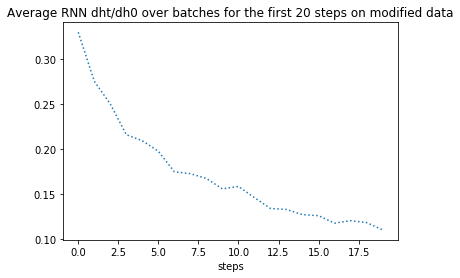

In [13]:
# Mean absolute gradients over steps
steps_20= [t for t in range(20)]
plt.plot(steps_20, dhtdh0_agg, linestyle= 'dotted')
plt.title('Average RNN dht/dh0 over batches for the first 20 steps on modified data')
plt.xlabel('steps')
plt.savefig('/Users/necromancerchenmy/Desktop/honours_thesis/thesis/thesis_proposal/thesis proposal/rnn_dhtdh0_20_mod.png')



#### LSTM grads

In [16]:
ds = tf.data.Dataset.from_tensor_slices((longmod_pad, ym)).batch(100)

@tf.function
# Compute gradients
def compute_dct_dc0(t, x, c0):
    return tf.gradients(model_lstm_mod(x)[:,t,:], c0)

n_b = int(longmod_pad.shape[0]/ 100)  # 400 batches
n_steps = 20   # look up only the first and last 20 steps

dctdc0_all= tf.zeros([n_b, n_steps])
for b, (x_batch_train, y_batch_train) in enumerate(ds):  # batches 0,1
    grad_batch= []   # a list of 1403 scalar gradients on the current batch
    for t in range(20):  
        # steps 0,...,19
        dctdc0_b_t = compute_dct_dc0(t, x_batch_train, c0)  # (batch_size, n_units)
        grad_t = tf.reduce_mean(abs(dctdc0_b_t[0]), [0,1]) # Scalar dctdc0 at the current batch and step
        print('step', t+1, 'of batch' ,b+1, 'done')
        grad_batch.append(grad_t)
    
    dctdc0_all= tf.concat([dctdc0_all, [grad_batch]], axis = 0)   

dctdc0_agg= tf.reduce_mean(dctdc0_all, 0)  # take rowmean to obtain a vector of shape (20,)
print(dctdc0_agg.shape)

step 1 of batch 1 done
step 2 of batch 1 done
step 3 of batch 1 done
step 4 of batch 1 done
step 5 of batch 1 done
step 6 of batch 1 done
step 7 of batch 1 done
step 8 of batch 1 done
step 9 of batch 1 done
step 10 of batch 1 done
step 11 of batch 1 done
step 12 of batch 1 done
step 13 of batch 1 done
step 14 of batch 1 done
step 15 of batch 1 done
step 16 of batch 1 done
step 17 of batch 1 done
step 18 of batch 1 done
step 19 of batch 1 done
step 20 of batch 1 done
step 1 of batch 2 done
step 2 of batch 2 done
step 3 of batch 2 done
step 4 of batch 2 done
step 5 of batch 2 done
step 6 of batch 2 done
step 7 of batch 2 done
step 8 of batch 2 done
step 9 of batch 2 done
step 10 of batch 2 done
step 11 of batch 2 done
step 12 of batch 2 done
step 13 of batch 2 done
step 14 of batch 2 done
step 15 of batch 2 done
step 16 of batch 2 done
step 17 of batch 2 done
step 18 of batch 2 done
step 19 of batch 2 done
step 20 of batch 2 done
step 1 of batch 3 done
step 2 of batch 3 done
step 3 of ba

step 6 of batch 15 done
step 7 of batch 15 done
step 8 of batch 15 done
step 9 of batch 15 done
step 10 of batch 15 done
step 11 of batch 15 done
step 12 of batch 15 done
step 13 of batch 15 done
step 14 of batch 15 done
step 15 of batch 15 done
step 16 of batch 15 done
step 17 of batch 15 done
step 18 of batch 15 done
step 19 of batch 15 done
step 20 of batch 15 done
step 1 of batch 16 done
step 2 of batch 16 done
step 3 of batch 16 done
step 4 of batch 16 done
step 5 of batch 16 done
step 6 of batch 16 done
step 7 of batch 16 done
step 8 of batch 16 done
step 9 of batch 16 done
step 10 of batch 16 done
step 11 of batch 16 done
step 12 of batch 16 done
step 13 of batch 16 done
step 14 of batch 16 done
step 15 of batch 16 done
step 16 of batch 16 done
step 17 of batch 16 done
step 18 of batch 16 done
step 19 of batch 16 done
step 20 of batch 16 done
step 1 of batch 17 done
step 2 of batch 17 done
step 3 of batch 17 done
step 4 of batch 17 done
step 5 of batch 17 done
step 6 of batch 17

step 20 of batch 31 done
step 1 of batch 32 done
step 2 of batch 32 done
step 3 of batch 32 done
step 4 of batch 32 done
step 5 of batch 32 done
step 6 of batch 32 done
step 7 of batch 32 done
step 8 of batch 32 done
step 9 of batch 32 done
step 10 of batch 32 done
step 11 of batch 32 done
step 12 of batch 32 done
step 13 of batch 32 done
step 14 of batch 32 done
step 15 of batch 32 done
step 16 of batch 32 done
step 17 of batch 32 done
step 18 of batch 32 done
step 19 of batch 32 done
step 20 of batch 32 done
step 1 of batch 33 done
step 2 of batch 33 done
step 3 of batch 33 done
step 4 of batch 33 done
step 5 of batch 33 done
step 6 of batch 33 done
step 7 of batch 33 done
step 8 of batch 33 done
step 9 of batch 33 done
step 10 of batch 33 done
step 11 of batch 33 done
step 12 of batch 33 done
step 13 of batch 33 done
step 14 of batch 33 done
step 15 of batch 33 done
step 16 of batch 33 done
step 17 of batch 33 done
step 18 of batch 33 done
step 19 of batch 33 done
step 20 of batch 3

step 14 of batch 48 done
step 15 of batch 48 done
step 16 of batch 48 done
step 17 of batch 48 done
step 18 of batch 48 done
step 19 of batch 48 done
step 20 of batch 48 done
step 1 of batch 49 done
step 2 of batch 49 done
step 3 of batch 49 done
step 4 of batch 49 done
step 5 of batch 49 done
step 6 of batch 49 done
step 7 of batch 49 done
step 8 of batch 49 done
step 9 of batch 49 done
step 10 of batch 49 done
step 11 of batch 49 done
step 12 of batch 49 done
step 13 of batch 49 done
step 14 of batch 49 done
step 15 of batch 49 done
step 16 of batch 49 done
step 17 of batch 49 done
step 18 of batch 49 done
step 19 of batch 49 done
step 20 of batch 49 done
step 1 of batch 50 done
step 2 of batch 50 done
step 3 of batch 50 done
step 4 of batch 50 done
step 5 of batch 50 done
step 6 of batch 50 done
step 7 of batch 50 done
step 8 of batch 50 done
step 9 of batch 50 done
step 10 of batch 50 done
step 11 of batch 50 done
step 12 of batch 50 done
step 13 of batch 50 done
step 14 of batch 5

step 8 of batch 65 done
step 9 of batch 65 done
step 10 of batch 65 done
step 11 of batch 65 done
step 12 of batch 65 done
step 13 of batch 65 done
step 14 of batch 65 done
step 15 of batch 65 done
step 16 of batch 65 done
step 17 of batch 65 done
step 18 of batch 65 done
step 19 of batch 65 done
step 20 of batch 65 done
step 1 of batch 66 done
step 2 of batch 66 done
step 3 of batch 66 done
step 4 of batch 66 done
step 5 of batch 66 done
step 6 of batch 66 done
step 7 of batch 66 done
step 8 of batch 66 done
step 9 of batch 66 done
step 10 of batch 66 done
step 11 of batch 66 done
step 12 of batch 66 done
step 13 of batch 66 done
step 14 of batch 66 done
step 15 of batch 66 done
step 16 of batch 66 done
step 17 of batch 66 done
step 18 of batch 66 done
step 19 of batch 66 done
step 20 of batch 66 done
step 1 of batch 67 done
step 2 of batch 67 done
step 3 of batch 67 done
step 4 of batch 67 done
step 5 of batch 67 done
step 6 of batch 67 done
step 7 of batch 67 done
step 8 of batch 67

step 2 of batch 82 done
step 3 of batch 82 done
step 4 of batch 82 done
step 5 of batch 82 done
step 6 of batch 82 done
step 7 of batch 82 done
step 8 of batch 82 done
step 9 of batch 82 done
step 10 of batch 82 done
step 11 of batch 82 done
step 12 of batch 82 done
step 13 of batch 82 done
step 14 of batch 82 done
step 15 of batch 82 done
step 16 of batch 82 done
step 17 of batch 82 done
step 18 of batch 82 done
step 19 of batch 82 done
step 20 of batch 82 done
step 1 of batch 83 done
step 2 of batch 83 done
step 3 of batch 83 done
step 4 of batch 83 done
step 5 of batch 83 done
step 6 of batch 83 done
step 7 of batch 83 done
step 8 of batch 83 done
step 9 of batch 83 done
step 10 of batch 83 done
step 11 of batch 83 done
step 12 of batch 83 done
step 13 of batch 83 done
step 14 of batch 83 done
step 15 of batch 83 done
step 16 of batch 83 done
step 17 of batch 83 done
step 18 of batch 83 done
step 19 of batch 83 done
step 20 of batch 83 done
step 1 of batch 84 done
step 2 of batch 84

step 16 of batch 98 done
step 17 of batch 98 done
step 18 of batch 98 done
step 19 of batch 98 done
step 20 of batch 98 done
step 1 of batch 99 done
step 2 of batch 99 done
step 3 of batch 99 done
step 4 of batch 99 done
step 5 of batch 99 done
step 6 of batch 99 done
step 7 of batch 99 done
step 8 of batch 99 done
step 9 of batch 99 done
step 10 of batch 99 done
step 11 of batch 99 done
step 12 of batch 99 done
step 13 of batch 99 done
step 14 of batch 99 done
step 15 of batch 99 done
step 16 of batch 99 done
step 17 of batch 99 done
step 18 of batch 99 done
step 19 of batch 99 done
step 20 of batch 99 done
step 1 of batch 100 done
step 2 of batch 100 done
step 3 of batch 100 done
step 4 of batch 100 done
step 5 of batch 100 done
step 6 of batch 100 done
step 7 of batch 100 done
step 8 of batch 100 done
step 9 of batch 100 done
step 10 of batch 100 done
step 11 of batch 100 done
step 12 of batch 100 done
step 13 of batch 100 done
step 14 of batch 100 done
step 15 of batch 100 done
ste

step 18 of batch 114 done
step 19 of batch 114 done
step 20 of batch 114 done
step 1 of batch 115 done
step 2 of batch 115 done
step 3 of batch 115 done
step 4 of batch 115 done
step 5 of batch 115 done
step 6 of batch 115 done
step 7 of batch 115 done
step 8 of batch 115 done
step 9 of batch 115 done
step 10 of batch 115 done
step 11 of batch 115 done
step 12 of batch 115 done
step 13 of batch 115 done
step 14 of batch 115 done
step 15 of batch 115 done
step 16 of batch 115 done
step 17 of batch 115 done
step 18 of batch 115 done
step 19 of batch 115 done
step 20 of batch 115 done
step 1 of batch 116 done
step 2 of batch 116 done
step 3 of batch 116 done
step 4 of batch 116 done
step 5 of batch 116 done
step 6 of batch 116 done
step 7 of batch 116 done
step 8 of batch 116 done
step 9 of batch 116 done
step 10 of batch 116 done
step 11 of batch 116 done
step 12 of batch 116 done
step 13 of batch 116 done
step 14 of batch 116 done
step 15 of batch 116 done
step 16 of batch 116 done
step

step 19 of batch 130 done
step 20 of batch 130 done
step 1 of batch 131 done
step 2 of batch 131 done
step 3 of batch 131 done
step 4 of batch 131 done
step 5 of batch 131 done
step 6 of batch 131 done
step 7 of batch 131 done
step 8 of batch 131 done
step 9 of batch 131 done
step 10 of batch 131 done
step 11 of batch 131 done
step 12 of batch 131 done
step 13 of batch 131 done
step 14 of batch 131 done
step 15 of batch 131 done
step 16 of batch 131 done
step 17 of batch 131 done
step 18 of batch 131 done
step 19 of batch 131 done
step 20 of batch 131 done
step 1 of batch 132 done
step 2 of batch 132 done
step 3 of batch 132 done
step 4 of batch 132 done
step 5 of batch 132 done
step 6 of batch 132 done
step 7 of batch 132 done
step 8 of batch 132 done
step 9 of batch 132 done
step 10 of batch 132 done
step 11 of batch 132 done
step 12 of batch 132 done
step 13 of batch 132 done
step 14 of batch 132 done
step 15 of batch 132 done
step 16 of batch 132 done
step 17 of batch 132 done
step

step 20 of batch 146 done
step 1 of batch 147 done
step 2 of batch 147 done
step 3 of batch 147 done
step 4 of batch 147 done
step 5 of batch 147 done
step 6 of batch 147 done
step 7 of batch 147 done
step 8 of batch 147 done
step 9 of batch 147 done
step 10 of batch 147 done
step 11 of batch 147 done
step 12 of batch 147 done
step 13 of batch 147 done
step 14 of batch 147 done
step 15 of batch 147 done
step 16 of batch 147 done
step 17 of batch 147 done
step 18 of batch 147 done
step 19 of batch 147 done
step 20 of batch 147 done
step 1 of batch 148 done
step 2 of batch 148 done
step 3 of batch 148 done
step 4 of batch 148 done
step 5 of batch 148 done
step 6 of batch 148 done
step 7 of batch 148 done
step 8 of batch 148 done
step 9 of batch 148 done
step 10 of batch 148 done
step 11 of batch 148 done
step 12 of batch 148 done
step 13 of batch 148 done
step 14 of batch 148 done
step 15 of batch 148 done
step 16 of batch 148 done
step 17 of batch 148 done
step 18 of batch 148 done
step

step 1 of batch 163 done
step 2 of batch 163 done
step 3 of batch 163 done
step 4 of batch 163 done
step 5 of batch 163 done
step 6 of batch 163 done
step 7 of batch 163 done
step 8 of batch 163 done
step 9 of batch 163 done
step 10 of batch 163 done
step 11 of batch 163 done
step 12 of batch 163 done
step 13 of batch 163 done
step 14 of batch 163 done
step 15 of batch 163 done
step 16 of batch 163 done
step 17 of batch 163 done
step 18 of batch 163 done
step 19 of batch 163 done
step 20 of batch 163 done
step 1 of batch 164 done
step 2 of batch 164 done
step 3 of batch 164 done
step 4 of batch 164 done
step 5 of batch 164 done
step 6 of batch 164 done
step 7 of batch 164 done
step 8 of batch 164 done
step 9 of batch 164 done
step 10 of batch 164 done
step 11 of batch 164 done
step 12 of batch 164 done
step 13 of batch 164 done
step 14 of batch 164 done
step 15 of batch 164 done
step 16 of batch 164 done
step 17 of batch 164 done
step 18 of batch 164 done
step 19 of batch 164 done
step

step 2 of batch 179 done
step 3 of batch 179 done
step 4 of batch 179 done
step 5 of batch 179 done
step 6 of batch 179 done
step 7 of batch 179 done
step 8 of batch 179 done
step 9 of batch 179 done
step 10 of batch 179 done
step 11 of batch 179 done
step 12 of batch 179 done
step 13 of batch 179 done
step 14 of batch 179 done
step 15 of batch 179 done
step 16 of batch 179 done
step 17 of batch 179 done
step 18 of batch 179 done
step 19 of batch 179 done
step 20 of batch 179 done
step 1 of batch 180 done
step 2 of batch 180 done
step 3 of batch 180 done
step 4 of batch 180 done
step 5 of batch 180 done
step 6 of batch 180 done
step 7 of batch 180 done
step 8 of batch 180 done
step 9 of batch 180 done
step 10 of batch 180 done
step 11 of batch 180 done
step 12 of batch 180 done
step 13 of batch 180 done
step 14 of batch 180 done
step 15 of batch 180 done
step 16 of batch 180 done
step 17 of batch 180 done
step 18 of batch 180 done
step 19 of batch 180 done
step 20 of batch 180 done
ste

step 3 of batch 195 done
step 4 of batch 195 done
step 5 of batch 195 done
step 6 of batch 195 done
step 7 of batch 195 done
step 8 of batch 195 done
step 9 of batch 195 done
step 10 of batch 195 done
step 11 of batch 195 done
step 12 of batch 195 done
step 13 of batch 195 done
step 14 of batch 195 done
step 15 of batch 195 done
step 16 of batch 195 done
step 17 of batch 195 done
step 18 of batch 195 done
step 19 of batch 195 done
step 20 of batch 195 done
step 1 of batch 196 done
step 2 of batch 196 done
step 3 of batch 196 done
step 4 of batch 196 done
step 5 of batch 196 done
step 6 of batch 196 done
step 7 of batch 196 done
step 8 of batch 196 done
step 9 of batch 196 done
step 10 of batch 196 done
step 11 of batch 196 done
step 12 of batch 196 done
step 13 of batch 196 done
step 14 of batch 196 done
step 15 of batch 196 done
step 16 of batch 196 done
step 17 of batch 196 done
step 18 of batch 196 done
step 19 of batch 196 done
step 20 of batch 196 done
step 1 of batch 197 done
ste

step 4 of batch 211 done
step 5 of batch 211 done
step 6 of batch 211 done
step 7 of batch 211 done
step 8 of batch 211 done
step 9 of batch 211 done
step 10 of batch 211 done
step 11 of batch 211 done
step 12 of batch 211 done
step 13 of batch 211 done
step 14 of batch 211 done
step 15 of batch 211 done
step 16 of batch 211 done
step 17 of batch 211 done
step 18 of batch 211 done
step 19 of batch 211 done
step 20 of batch 211 done
step 1 of batch 212 done
step 2 of batch 212 done
step 3 of batch 212 done
step 4 of batch 212 done
step 5 of batch 212 done
step 6 of batch 212 done
step 7 of batch 212 done
step 8 of batch 212 done
step 9 of batch 212 done
step 10 of batch 212 done
step 11 of batch 212 done
step 12 of batch 212 done
step 13 of batch 212 done
step 14 of batch 212 done
step 15 of batch 212 done
step 16 of batch 212 done
step 17 of batch 212 done
step 18 of batch 212 done
step 19 of batch 212 done
step 20 of batch 212 done
step 1 of batch 213 done
step 2 of batch 213 done
ste

step 5 of batch 227 done
step 6 of batch 227 done
step 7 of batch 227 done
step 8 of batch 227 done
step 9 of batch 227 done
step 10 of batch 227 done
step 11 of batch 227 done
step 12 of batch 227 done
step 13 of batch 227 done
step 14 of batch 227 done
step 15 of batch 227 done
step 16 of batch 227 done
step 17 of batch 227 done
step 18 of batch 227 done
step 19 of batch 227 done
step 20 of batch 227 done
step 1 of batch 228 done
step 2 of batch 228 done
step 3 of batch 228 done
step 4 of batch 228 done
step 5 of batch 228 done
step 6 of batch 228 done
step 7 of batch 228 done
step 8 of batch 228 done
step 9 of batch 228 done
step 10 of batch 228 done
step 11 of batch 228 done
step 12 of batch 228 done
step 13 of batch 228 done
step 14 of batch 228 done
step 15 of batch 228 done
step 16 of batch 228 done
step 17 of batch 228 done
step 18 of batch 228 done
step 19 of batch 228 done
step 20 of batch 228 done
step 1 of batch 229 done
step 2 of batch 229 done
step 3 of batch 229 done
ste

step 6 of batch 243 done
step 7 of batch 243 done
step 8 of batch 243 done
step 9 of batch 243 done
step 10 of batch 243 done
step 11 of batch 243 done
step 12 of batch 243 done
step 13 of batch 243 done
step 14 of batch 243 done
step 15 of batch 243 done
step 16 of batch 243 done
step 17 of batch 243 done
step 18 of batch 243 done
step 19 of batch 243 done
step 20 of batch 243 done
step 1 of batch 244 done
step 2 of batch 244 done
step 3 of batch 244 done
step 4 of batch 244 done
step 5 of batch 244 done
step 6 of batch 244 done
step 7 of batch 244 done
step 8 of batch 244 done
step 9 of batch 244 done
step 10 of batch 244 done
step 11 of batch 244 done
step 12 of batch 244 done
step 13 of batch 244 done
step 14 of batch 244 done
step 15 of batch 244 done
step 16 of batch 244 done
step 17 of batch 244 done
step 18 of batch 244 done
step 19 of batch 244 done
step 20 of batch 244 done
step 1 of batch 245 done
step 2 of batch 245 done
step 3 of batch 245 done
step 4 of batch 245 done
ste

step 7 of batch 259 done
step 8 of batch 259 done
step 9 of batch 259 done
step 10 of batch 259 done
step 11 of batch 259 done
step 12 of batch 259 done
step 13 of batch 259 done
step 14 of batch 259 done
step 15 of batch 259 done
step 16 of batch 259 done
step 17 of batch 259 done
step 18 of batch 259 done
step 19 of batch 259 done
step 20 of batch 259 done
step 1 of batch 260 done
step 2 of batch 260 done
step 3 of batch 260 done
step 4 of batch 260 done
step 5 of batch 260 done
step 6 of batch 260 done
step 7 of batch 260 done
step 8 of batch 260 done
step 9 of batch 260 done
step 10 of batch 260 done
step 11 of batch 260 done
step 12 of batch 260 done
step 13 of batch 260 done
step 14 of batch 260 done
step 15 of batch 260 done
step 16 of batch 260 done
step 17 of batch 260 done
step 18 of batch 260 done
step 19 of batch 260 done
step 20 of batch 260 done
step 1 of batch 261 done
step 2 of batch 261 done
step 3 of batch 261 done
step 4 of batch 261 done
step 5 of batch 261 done
ste

step 8 of batch 275 done
step 9 of batch 275 done
step 10 of batch 275 done
step 11 of batch 275 done
step 12 of batch 275 done
step 13 of batch 275 done
step 14 of batch 275 done
step 15 of batch 275 done
step 16 of batch 275 done
step 17 of batch 275 done
step 18 of batch 275 done
step 19 of batch 275 done
step 20 of batch 275 done
step 1 of batch 276 done
step 2 of batch 276 done
step 3 of batch 276 done
step 4 of batch 276 done
step 5 of batch 276 done
step 6 of batch 276 done
step 7 of batch 276 done
step 8 of batch 276 done
step 9 of batch 276 done
step 10 of batch 276 done
step 11 of batch 276 done
step 12 of batch 276 done
step 13 of batch 276 done
step 14 of batch 276 done
step 15 of batch 276 done
step 16 of batch 276 done
step 17 of batch 276 done
step 18 of batch 276 done
step 19 of batch 276 done
step 20 of batch 276 done
step 1 of batch 277 done
step 2 of batch 277 done
step 3 of batch 277 done
step 4 of batch 277 done
step 5 of batch 277 done
step 6 of batch 277 done
ste

step 9 of batch 291 done
step 10 of batch 291 done
step 11 of batch 291 done
step 12 of batch 291 done
step 13 of batch 291 done
step 14 of batch 291 done
step 15 of batch 291 done
step 16 of batch 291 done
step 17 of batch 291 done
step 18 of batch 291 done
step 19 of batch 291 done
step 20 of batch 291 done
step 1 of batch 292 done
step 2 of batch 292 done
step 3 of batch 292 done
step 4 of batch 292 done
step 5 of batch 292 done
step 6 of batch 292 done
step 7 of batch 292 done
step 8 of batch 292 done
step 9 of batch 292 done
step 10 of batch 292 done
step 11 of batch 292 done
step 12 of batch 292 done
step 13 of batch 292 done
step 14 of batch 292 done
step 15 of batch 292 done
step 16 of batch 292 done
step 17 of batch 292 done
step 18 of batch 292 done
step 19 of batch 292 done
step 20 of batch 292 done
step 1 of batch 293 done
step 2 of batch 293 done
step 3 of batch 293 done
step 4 of batch 293 done
step 5 of batch 293 done
step 6 of batch 293 done
step 7 of batch 293 done
ste

step 10 of batch 307 done
step 11 of batch 307 done
step 12 of batch 307 done
step 13 of batch 307 done
step 14 of batch 307 done
step 15 of batch 307 done
step 16 of batch 307 done
step 17 of batch 307 done
step 18 of batch 307 done
step 19 of batch 307 done
step 20 of batch 307 done
step 1 of batch 308 done
step 2 of batch 308 done
step 3 of batch 308 done
step 4 of batch 308 done
step 5 of batch 308 done
step 6 of batch 308 done
step 7 of batch 308 done
step 8 of batch 308 done
step 9 of batch 308 done
step 10 of batch 308 done
step 11 of batch 308 done
step 12 of batch 308 done
step 13 of batch 308 done
step 14 of batch 308 done
step 15 of batch 308 done
step 16 of batch 308 done
step 17 of batch 308 done
step 18 of batch 308 done
step 19 of batch 308 done
step 20 of batch 308 done
step 1 of batch 309 done
step 2 of batch 309 done
step 3 of batch 309 done
step 4 of batch 309 done
step 5 of batch 309 done
step 6 of batch 309 done
step 7 of batch 309 done
step 8 of batch 309 done
ste

step 11 of batch 323 done
step 12 of batch 323 done
step 13 of batch 323 done
step 14 of batch 323 done
step 15 of batch 323 done
step 16 of batch 323 done
step 17 of batch 323 done
step 18 of batch 323 done
step 19 of batch 323 done
step 20 of batch 323 done
step 1 of batch 324 done
step 2 of batch 324 done
step 3 of batch 324 done
step 4 of batch 324 done
step 5 of batch 324 done
step 6 of batch 324 done
step 7 of batch 324 done
step 8 of batch 324 done
step 9 of batch 324 done
step 10 of batch 324 done
step 11 of batch 324 done
step 12 of batch 324 done
step 13 of batch 324 done
step 14 of batch 324 done
step 15 of batch 324 done
step 16 of batch 324 done
step 17 of batch 324 done
step 18 of batch 324 done
step 19 of batch 324 done
step 20 of batch 324 done
step 1 of batch 325 done
step 2 of batch 325 done
step 3 of batch 325 done
step 4 of batch 325 done
step 5 of batch 325 done
step 6 of batch 325 done
step 7 of batch 325 done
step 8 of batch 325 done
step 9 of batch 325 done
step

step 12 of batch 339 done
step 13 of batch 339 done
step 14 of batch 339 done
step 15 of batch 339 done
step 16 of batch 339 done
step 17 of batch 339 done
step 18 of batch 339 done
step 19 of batch 339 done
step 20 of batch 339 done
step 1 of batch 340 done
step 2 of batch 340 done
step 3 of batch 340 done
step 4 of batch 340 done
step 5 of batch 340 done
step 6 of batch 340 done
step 7 of batch 340 done
step 8 of batch 340 done
step 9 of batch 340 done
step 10 of batch 340 done
step 11 of batch 340 done
step 12 of batch 340 done
step 13 of batch 340 done
step 14 of batch 340 done
step 15 of batch 340 done
step 16 of batch 340 done
step 17 of batch 340 done
step 18 of batch 340 done
step 19 of batch 340 done
step 20 of batch 340 done
step 1 of batch 341 done
step 2 of batch 341 done
step 3 of batch 341 done
step 4 of batch 341 done
step 5 of batch 341 done
step 6 of batch 341 done
step 7 of batch 341 done
step 8 of batch 341 done
step 9 of batch 341 done
step 10 of batch 341 done
step

step 13 of batch 355 done
step 14 of batch 355 done
step 15 of batch 355 done
step 16 of batch 355 done
step 17 of batch 355 done
step 18 of batch 355 done
step 19 of batch 355 done
step 20 of batch 355 done
step 1 of batch 356 done
step 2 of batch 356 done
step 3 of batch 356 done
step 4 of batch 356 done
step 5 of batch 356 done
step 6 of batch 356 done
step 7 of batch 356 done
step 8 of batch 356 done
step 9 of batch 356 done
step 10 of batch 356 done
step 11 of batch 356 done
step 12 of batch 356 done
step 13 of batch 356 done
step 14 of batch 356 done
step 15 of batch 356 done
step 16 of batch 356 done
step 17 of batch 356 done
step 18 of batch 356 done
step 19 of batch 356 done
step 20 of batch 356 done
step 1 of batch 357 done
step 2 of batch 357 done
step 3 of batch 357 done
step 4 of batch 357 done
step 5 of batch 357 done
step 6 of batch 357 done
step 7 of batch 357 done
step 8 of batch 357 done
step 9 of batch 357 done
step 10 of batch 357 done
step 11 of batch 357 done
step

step 14 of batch 371 done
step 15 of batch 371 done
step 16 of batch 371 done
step 17 of batch 371 done
step 18 of batch 371 done
step 19 of batch 371 done
step 20 of batch 371 done
step 1 of batch 372 done
step 2 of batch 372 done
step 3 of batch 372 done
step 4 of batch 372 done
step 5 of batch 372 done
step 6 of batch 372 done
step 7 of batch 372 done
step 8 of batch 372 done
step 9 of batch 372 done
step 10 of batch 372 done
step 11 of batch 372 done
step 12 of batch 372 done
step 13 of batch 372 done
step 14 of batch 372 done
step 15 of batch 372 done
step 16 of batch 372 done
step 17 of batch 372 done
step 18 of batch 372 done
step 19 of batch 372 done
step 20 of batch 372 done
step 1 of batch 373 done
step 2 of batch 373 done
step 3 of batch 373 done
step 4 of batch 373 done
step 5 of batch 373 done
step 6 of batch 373 done
step 7 of batch 373 done
step 8 of batch 373 done
step 9 of batch 373 done
step 10 of batch 373 done
step 11 of batch 373 done
step 12 of batch 373 done
step

step 15 of batch 387 done
step 16 of batch 387 done
step 17 of batch 387 done
step 18 of batch 387 done
step 19 of batch 387 done
step 20 of batch 387 done
step 1 of batch 388 done
step 2 of batch 388 done
step 3 of batch 388 done
step 4 of batch 388 done
step 5 of batch 388 done
step 6 of batch 388 done
step 7 of batch 388 done
step 8 of batch 388 done
step 9 of batch 388 done
step 10 of batch 388 done
step 11 of batch 388 done
step 12 of batch 388 done
step 13 of batch 388 done
step 14 of batch 388 done
step 15 of batch 388 done
step 16 of batch 388 done
step 17 of batch 388 done
step 18 of batch 388 done
step 19 of batch 388 done
step 20 of batch 388 done
step 1 of batch 389 done
step 2 of batch 389 done
step 3 of batch 389 done
step 4 of batch 389 done
step 5 of batch 389 done
step 6 of batch 389 done
step 7 of batch 389 done
step 8 of batch 389 done
step 9 of batch 389 done
step 10 of batch 389 done
step 11 of batch 389 done
step 12 of batch 389 done
step 13 of batch 389 done
step

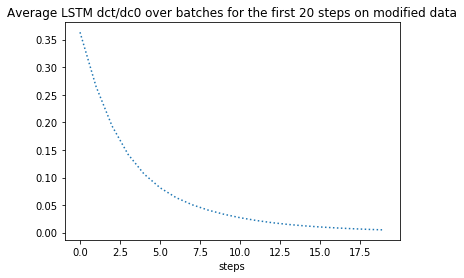

In [17]:
# Mean absolute gradients over steps
steps_20= [t for t in range(20)]
plt.plot(steps_20, dctdc0_agg, linestyle= 'dotted')
plt.title('Average LSTM dct/dc0 over batches for the first 20 steps on modified data')
plt.xlabel('steps')
plt.savefig('/Users/necromancerchenmy/Desktop/honours_thesis/thesis/thesis_proposal/thesis proposal/lstm_dctdc0_20_mod.png')


## Last 20 steps

In [ ]:
ds = tf.data.Dataset.from_tensor_slices((longmod_pad[20000:], ym[20000:])).batch(100)

@tf.function
# Compute gradients
def compute_dht_dh0(t, x, h0):
    return tf.gradients(model_rnn_mod(x)[:,t,:], h0)

n_b = int(20000/ 100)  # 200 batches
n_steps = 20   # look up only the first and last 20 steps

dhtdh0_last20= tf.zeros([n_b, n_steps])
for b, (x_batch_train, y_batch_train) in enumerate(ds):  # batches 0,1
    grad_batch= []   # a list of 1403 scalar gradients on the current batch
    for t in range(input_length_m - n_steps, input_length_m):  
        dhtdh0_b_t = compute_dht_dh0(t, x_batch_train, h0)  # (batch_size, n_units)
        grad_t = tf.reduce_mean(abs(dhtdh0_b_t[0]), [0,1]) # Scalar dctdc0 at the current batch and step
        print('step', t+1, 'of batch' ,b+1, 'done')
        grad_batch.append(grad_t)
    
    dhtdh0_last20= tf.concat([dhtdh0_last20, [grad_batch]], axis = 0)   

dhtdh0_last20_agg= tf.reduce_mean(dhtdh0_last20, 0)  # take rowmean to obtain a vector of shape (20,)
print(dhtdh0_last20_agg.shape)


In [ ]:
# Mean absolute gradients over steps
steps_20= [t for t in range(input_length_m - n_steps, input_length_m)]
plt.plot(steps_20, dhtdh0_last20_agg, linestyle= 'dotted')
plt.title('Average RNN dht/dh0 over batches for the last 20 steps on modified data')
plt.xlabel('steps')
plt.savefig('/Users/necromancerchenmy/Desktop/honours_thesis/thesis/thesis_proposal/thesis proposal/rnn_dhtdh0_last20_mod.png')


In [21]:
nrows= 400
ds = tf.data.Dataset.from_tensor_slices((longmod_pad[:nrows], ym[:nrows])).batch(100)

@tf.function
# Compute gradients
def compute_dct_dc0(t, x, c0):
    return tf.gradients(model_lstm_mod(x)[:,t,:], c0)

n_b = int(nrows/ 100)  # 10 batches
n_steps = 20   # look up only the first and last 20 steps

dctdc0_last20= tf.zeros([n_b, n_steps])
for b, (x_batch_train, y_batch_train) in enumerate(ds):  # batches 0,1
    grad_batch= []   # a list of 1403 scalar gradients on the current batch
    for t in range(input_length_m - n_steps, input_length_m):  
        dctdc0_b_t = compute_dct_dc0(t, x_batch_train, c0)  # (batch_size, n_units)
        grad_t = tf.reduce_mean(abs(dctdc0_b_t[0]), [0,1]) # Scalar dctdc0 at the current batch and step
        print('step', t+1, 'of batch' ,b+1, 'done')
        grad_batch.append(grad_t)
    
    dctdc0_last20= tf.concat([dctdc0_last20, [grad_batch]], axis = 0)   

dctdc0_last20_agg= tf.reduce_mean(dctdc0_last20, 0)  # take rowmean to obtain a vector of shape (20,)
print(dctdc0_last20_agg.shape)


step 2302 of batch 1 done
step 2303 of batch 1 done
step 2304 of batch 1 done
step 2305 of batch 1 done
step 2306 of batch 1 done
step 2307 of batch 1 done
step 2308 of batch 1 done
step 2309 of batch 1 done
step 2310 of batch 1 done
step 2311 of batch 1 done
step 2312 of batch 1 done
step 2313 of batch 1 done
step 2314 of batch 1 done
step 2315 of batch 1 done
step 2316 of batch 1 done
step 2317 of batch 1 done
step 2318 of batch 1 done
step 2319 of batch 1 done
step 2320 of batch 1 done
step 2321 of batch 1 done
step 2302 of batch 2 done
step 2303 of batch 2 done
step 2304 of batch 2 done
step 2305 of batch 2 done
step 2306 of batch 2 done
step 2307 of batch 2 done
step 2308 of batch 2 done
step 2309 of batch 2 done
step 2310 of batch 2 done
step 2311 of batch 2 done
step 2312 of batch 2 done
step 2313 of batch 2 done
step 2314 of batch 2 done
step 2315 of batch 2 done
step 2316 of batch 2 done
step 2317 of batch 2 done
step 2318 of batch 2 done
step 2319 of batch 2 done
step 2320 of

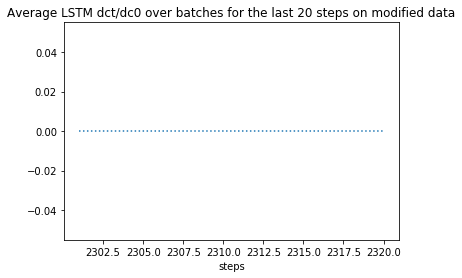

In [26]:
# Mean absolute gradients over steps
steps_20= [t for t in range(input_length_m - n_steps, input_length_m)]
plt.plot(steps_20, dctdc0_last20_agg, linestyle= 'dotted')
plt.title('Average LSTM dct/dc0 over batches for the last 20 steps on modified data')
plt.xlabel('steps')
plt.show()
#plt.savefig('/Users/necromancerchenmy/Desktop/honours_thesis/thesis/thesis_proposal/thesis proposal/lstm_dctdc0_last20_mod.png')


In [25]:
dctdc0_last20_agg

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>